## RNN and time series forecasting

In [71]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf

## Loading the dataset and setting simple column names

In [2]:
path = Path("datasets/CTA_-_Ridership_-_Daily_Boarding_Totals_20240221.csv")

df = pd.read_csv(path, parse_dates=["service_date"])

df.columns = ["date", "day_type", "bus", "rail", "total"]

df = df.sort_values("date").set_index("date")

df = df.drop("total", axis=1)

df = df.drop_duplicates()

## Multivaried Time Series with strong seasonality

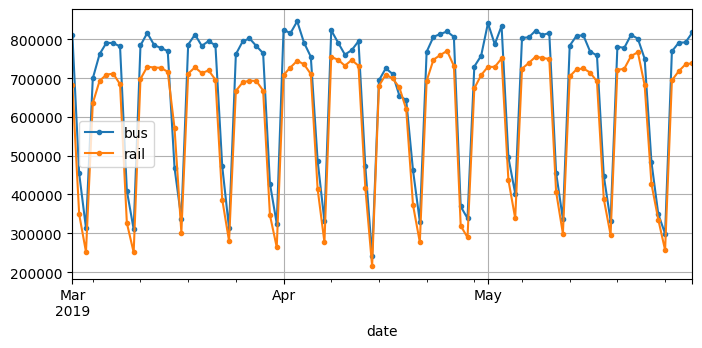

In [3]:
df["2019-03":"2019-05"].plot(grid=True, marker='.', figsize=(8, 3.5))
plt.show()

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


# DL ML Time Series modelling

## Automated windowing and batching a sequece of data

In [ ]:
my_series = [0, 1, 2, 3, 4, 5]

my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],
    sequence_length=3,
    batch_size=2
)

In [29]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

## Manual windowing

In [33]:
# Creates nested dataset of datasets
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    # Iterates over each sub-dataset of each window
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()
        

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [34]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(window_tensor)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)
tf.Tensor([2 3 4 5], shape=(4,), dtype=int64)


In [37]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    # Here lambda puts together the whole window into one sample
    # by batching each window dataset into length sized batches
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

## Three substrings batched into batches of 2, so one two-sample and one one-sample batch

In [38]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

## Train-Val-Test split and global normalization

In [64]:
rail_train = df['rail']["2016-01":"2018-12"] / 1e6
rail_valid = df['rail']["2019-01":"2019-05"] / 1e6
rail_test = df['rail']["2019-06":] / 1e6

## Datasets prepearation for ML

In [66]:
seq_length = 56

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)


## Forecasting with Linear Model

In [41]:
tf.random.set_seed(42)

# FC linear layer is the whole model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=opt,
              metrics=['mae'])


In [42]:
history = model.fit(train_ds, 
                    validation_data=valid_ds, 
                    epochs=500,
                   callbacks=[early_stopping_cb])

Epoch 1/500
 1/33 [..............................] - ETA: 36s - loss: 0.1993 - mae: 0.5624

2024-02-24 19:52:52.865076: I external/local_xla/xla/service/service.cc:168] XLA service 0x723ce956ea90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-24 19:52:52.865123: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-24 19:52:52.923099: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1708800772.982578    2865 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 [==============================] - 1s 6ms/step - loss: 0.0512 - mae: 0.2468 - val_loss: 0.0104 - val_mae: 0.1137
Epoch 2/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0082 - mae: 0.0940 - val_loss: 0.0079 - val_mae: 0.0931
Epoch 3/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0069 - mae: 0.0847 - val_loss: 0.0051 - val_mae: 0.0708
Epoch 4/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0062 - mae: 0.0797 - val_loss: 0.0053 - val_mae: 0.0702
Epoch 5/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0064 - mae: 0.0818 - val_loss: 0.0050 - val_mae: 0.0720
Epoch 6/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0056 - mae: 0.0767 - val_loss: 0.0049 - val_mae: 0.0669
Epoch 7/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0053 - mae: 0.0722 - val_loss: 0.0045 - val_mae: 0.0645
Epoch 8/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0050 - mae: 0.0710 -

## Reversing normalization to find VAL MAE in units of rides

In [43]:
0.0378 * 1e6

37800.0

## Simple RNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

### Based on just one recurrent neuron. Hidden state *h* is the previous output *y* and is initialized to 0

### Activation is *tanh*, which limits values range that RNN can produce

### RNN runs through the whole input sequence iteratively and by default outputs just the last value, but it can be configured to return values at each step of the input processing with *return_sequence=True*

### Such a one-neuron simple RNN  has just three parameters: one weight scalar for the current input *x*, one weight for the hidden state *h* and one bias.

### Its memory is very short, just one previous step. Simple Dense layer had already 56 steps and 57 parameters.

### input_shape here is *[None, 1]* reprezenting inputs *[batch_size, time_steps, dimensionality]*
### input_shape argument ignores the batch size, so we just specify arbitrary input sequence length and univariate time series

## RNN with more neurons and no output activation

In [68]:
tf.random.set_seed(42)

univar_model = tf.keras.Sequential([
    # This has 32 outputs with tanh activations
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    # This gives any output value range
    tf.keras.layers.Dense(1)
])

In [69]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

univar_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=opt,
              metrics=['mae'])

In [70]:
history = univar_model.fit(train_ds, 
                    validation_data=valid_ds, 
                    epochs=500,
                   callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0165 - mae: 0.1500 - val_loss: 0.0093 - val_mae: 0.1158
Epoch 2/500
33/33 [==============================] - 0s 14ms/step - loss: 0.0085 - mae: 0.1072 - val_loss: 0.0063 - val_mae: 0.0863
Epoch 3/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0062 - mae: 0.0862 - val_loss: 0.0041 - val_mae: 0.0665
Epoch 4/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0053 - mae: 0.0758 - val_loss: 0.0039 - val_mae: 0.0664
Epoch 5/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0048 - mae: 0.0694 - val_loss: 0.0034 - val_mae: 0.0611
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0045 - mae: 0.0663 - val_loss: 0.0028 - val_mae: 0.0533
Epoch 7/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0041 - mae: 0.0620 - val_loss: 0.0036 - val_mae: 0.0622
Epoch 8/500
33/33 [==============================] - 1s 21ms/step - loss: 0.

## Stacked deep RNN

In [ ]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1], return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

## Multivaried forecating with categorical variables

In [57]:
df_mulvar = df[['bus', 'rail']] / 1e6

In [58]:
# Tomorrow's day type is known so can be used as today's input
df_mulvar['next_day_type'] = df['day_type'].shift(-1)
df_mulvar = 1*pd.get_dummies(df_mulvar)

In [59]:
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0


In [60]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [67]:
seq_length = 56

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    # For two targets use mulvar_train[['bus', 'rail']][seq_length:]
    targets=mulvar_train['rail'][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
     # For two targets use mulvar_valid[['bus', 'rail']][seq_length:]
    targets=mulvar_valid['rail'][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)


In [62]:
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

## Forecasting multiple days ahead

In [72]:
# Preparing initial data stream of required length of seq_length from the validation set
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]

# Predicting recursively to next 14 days
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    # Appending prediction for self-regressive inference
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 32ms/step


array([0.245852  , 0.573542  , 0.627781  , 0.628514  , 0.348257  ,
       0.260556  , 0.66247   , 0.701693  , 0.685444  , 0.690162  ,
       0.679115  , 0.325219  , 0.250222  , 0.705571  , 0.720095  ,
       0.728048  , 0.734929  , 0.700006  , 0.312424  , 0.236744  ,
       0.401503  , 0.712125  , 0.718899  , 0.7113    , 0.590674  ,
       0.296063  , 0.221081  , 0.67881   , 0.579917  , 0.097917  ,
       0.243912  , 0.648091  , 0.34565   , 0.250724  , 0.718764  ,
       0.734181  , 0.727769  , 0.732351  , 0.655823  , 0.338847  ,
       0.251192  , 0.704667  , 0.698387  , 0.728764  , 0.746611  ,
       0.687932  , 0.362613  , 0.256817  , 0.519409  , 0.725195  ,
       0.717172  , 0.727504  , 0.702988  , 0.328179  , 0.240478  ,
       0.680844  , 0.72754806, 0.71287578, 0.7204563 , 0.70882922,
       0.41572696, 0.22688794, 0.64537412, 0.72102338, 0.71383017,
       0.71334726, 0.72210521, 0.4476037 , 0.21415699, 0.63772553])

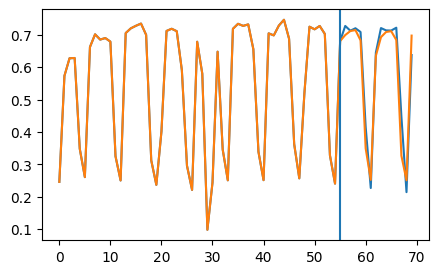

In [82]:
plt.figure(figsize=(5, 3))
plt.plot(X.flatten())
plt.plot(rail_valid.to_numpy()[:seq_length+14])
plt.axvline(x=seq_length-1)

## Training RNN to predict multiple days at once

### Change target to contain the required next N values and adjust model output accordingly

In [83]:
def split_inputs_and_targets(multivar_series, ahead=14, target_col=1):
    return multivar_series[:, :-ahead], multivar_series[:, -ahead:, target_col]

In [85]:
seq_length = 56

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [86]:
ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
# Prediction for ahead model
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
Y_pred = ahead_model.predict(X)

## seq2seq model, in wich gradient flows at each time step and not just from the last iteration

## Target is a sequence of ahead vectors, e.g. a sequence of 14-dim vectors containing consecutive time series elements

In [87]:
my_series = tf.data.Dataset.range(7)

In [89]:
list(my_series)

[<tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>,
 <tf.Tensor: shape=(), dtype=int64, numpy=5>,
 <tf.Tensor: shape=(), dtype=int64, numpy=6>]

In [90]:
# Consecutive windows shifted by 1 collected as vectors in a sequece
dataset = to_windows(to_windows(my_series, 3), 4)

In [92]:
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [94]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))

### Causal dataset for seq2seq: at each step of the input seqence of total length 4 the target is a vector of the two values following the last known value of the iput, e.g. [0, 1, 2] ->[3, 4]

In [95]:
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

## Seq2Seq Dataset

In [97]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [98]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

## seq2seq model: RNN outputs seq_length long sequences of 32-dim vectors projected to ahead-dim (14-dim) outputs

## TimeDistributed layer allows to apply any vector-to-vector layer to every vector in the input sequence by applying it to individual vectors across time dimension

In [99]:
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

## At inference we ignore all but last output, which is the next day forecast

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]

## For deeper networks unstable gradients can be mitigated with LayerNorm, proper initialization and dropout

## Custom RNN cell with LayerNorm introduced between layers

In [111]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                            activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        # This performs one atomic recurrence step
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        # For simple RNN both output and state are the same
        return norm_outputs, [norm_outputs]

In [112]:
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [113]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

custom_ln_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=opt,
              metrics=['mae'])

history = custom_ln_model.fit(seq2seq_train, 
                    validation_data=seq2seq_valid, 
                    epochs=500,
                   callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 2s 27ms/step - loss: 0.1042 - mae: 0.3332 - val_loss: 0.0258 - val_mae: 0.1816
Epoch 2/500
 7/33 [=====>........................] - ETA: 0s - loss: 0.0219 - mae: 0.1672

2024-02-27 12:58:48.551332: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12557110421212667331


33/33 [==============================] - 1s 23ms/step - loss: 0.0193 - mae: 0.1561 - val_loss: 0.0179 - val_mae: 0.1458
Epoch 3/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0157 - mae: 0.1435 - val_loss: 0.0161 - val_mae: 0.1367
Epoch 4/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0144 - mae: 0.1368 - val_loss: 0.0148 - val_mae: 0.1317
Epoch 5/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0134 - mae: 0.1319 - val_loss: 0.0139 - val_mae: 0.1273
Epoch 6/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0127 - mae: 0.1281 - val_loss: 0.0134 - val_mae: 0.1234
Epoch 7/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0120 - mae: 0.1239 - val_loss: 0.0126 - val_mae: 0.1200
Epoch 8/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0115 - mae: 0.1204 - val_loss: 0.0120 - val_mae: 0.1167
Epoch 9/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0110 - mae: 

## LSTM and the memory problem resolution

In [114]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

## Using Conv_1D for series preprocessing
### Allows to extend effective sequence length by downsampling input sequence
### With stride > 1 requires downsampling targets accordingly
### With kernel size n > 1 requires skipping first n - 1 steps from the target sequence


## Seq2Seq model based on Cond1D and GRU

In [116]:
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation='relu', input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

### Preparing longer sequence dataset and subsampling targets by 2 for model strides 2

In [120]:
longer_train_ds = to_seq2seq_dataset(mulvar_train, seq_length=112, shuffle=True, seed=42)
longer_valid_ds = to_seq2seq_dataset(mulvar_valid, seq_length=112)

In [121]:
downsampled_train = longer_train_ds.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid_ds.map(lambda X, Y: (X, Y[:, 3::2]))

In [123]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

conv_rnn_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=opt,
              metrics=['mae'])

history = conv_rnn_model.fit(downsampled_train, 
                    validation_data=downsampled_valid, 
                    epochs=500,
                   callbacks=[early_stopping_cb])

Epoch 1/500
     31/Unknown - 2s 8ms/step - loss: 0.1214 - mae: 0.4133

2024-02-27 16:27:50.840622: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3801153660580718616
2024-02-27 16:27:50.840707: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6986554802151014828
2024-02-27 16:27:50.840736: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 2333623075846752759
2024-02-27 16:27:50.840816: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6911846515729685053
2024-02-27 16:27:50.840828: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 8914637699694087021
2024-02-27 16:27:50.840837: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11762282275537085049


31/31 [==============================] - 2s 27ms/step - loss: 0.1214 - mae: 0.4133 - val_loss: 0.0247 - val_mae: 0.1832
Epoch 2/500
 1/31 [..............................] - ETA: 3s - loss: 0.0240 - mae: 0.1852

2024-02-27 16:27:51.390233: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13626309971902088370
2024-02-27 16:27:51.390271: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18088111993317147916


31/31 [==============================] - 0s 12ms/step - loss: 0.0190 - mae: 0.1563 - val_loss: 0.0189 - val_mae: 0.1512
Epoch 3/500
31/31 [==============================] - 1s 22ms/step - loss: 0.0164 - mae: 0.1539 - val_loss: 0.0179 - val_mae: 0.1475
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 0.0157 - mae: 0.1501 - val_loss: 0.0172 - val_mae: 0.1446
Epoch 5/500
31/31 [==============================] - 0s 9ms/step - loss: 0.0152 - mae: 0.1473 - val_loss: 0.0167 - val_mae: 0.1417
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 0.0146 - mae: 0.1448 - val_loss: 0.0162 - val_mae: 0.1389
Epoch 7/500
31/31 [==============================] - 0s 6ms/step - loss: 0.0142 - mae: 0.1416 - val_loss: 0.0157 - val_mae: 0.1364
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 0.0137 - mae: 0.1392 - val_loss: 0.0152 - val_mae: 0.1340
Epoch 9/500
31/31 [==============================] - 0s 6ms/step - loss: 0.0133 - mae: 0.1364

## Simple WaveNet: purely Conv1D architecture

### Properly explained causal padding: it ensues proper positioning of the next output element and hence causality. In causal padding receptive field of the last output does not see into the input sequence data ahead of this particular output, but also this kind of padding allows for predicting elements of the sequence from the very start. Otherwise one could use some later output position as the causal prediction result but this would have to be after some number of initial sequence elements were skipped (because Conv1D takes some number of sequence elements to produce one output).

* https://stats.stackexchange.com/questions/442264/using-causal-padding-ensures-conv-layers-does-not-peek-into-the-future-when-ma

In [125]:
wavenet_model = tf.keras.Sequential()

In [126]:
wavenet_model.add(tf.keras.layers.Input(shape=[None, 5]))

In [129]:
# Stacking two hypebolic blocks
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=2,
                                            # causal padding: lke same 
                                            # but adds zeros at the start of the sequence
                                            padding="causal",
                                            activation='relu',
                                            dilation_rate=rate))

# Adding output layer, which predicts 14 days ahead
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

In [130]:
wavenet_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 32)          352       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_7 (Conv1D)           (None, None, 32)        

In [131]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

wavenet_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=opt,
              metrics=['mae'])

history = wavenet_model.fit(longer_train_ds, 
                    validation_data=longer_valid_ds, 
                    epochs=5,
                   callbacks=[early_stopping_cb])

Epoch 1/5
31/31 [==============================] - 4s 54ms/step - loss: 0.1612 - mae: 0.5299 - val_loss: 0.0706 - val_mae: 0.3305
Epoch 2/5
25/31 [=======================>......] - ETA: 0s - loss: 0.0545 - mae: 0.2851

2024-02-28 12:10:57.246041: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 112884479399573261
2024-02-28 12:10:57.246066: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3078497524760410276


31/31 [==============================] - 0s 5ms/step - loss: 0.0498 - mae: 0.2715 - val_loss: 0.0231 - val_mae: 0.1919
Epoch 3/5
31/31 [==============================] - 0s 5ms/step - loss: 0.0197 - mae: 0.1752 - val_loss: 0.0190 - val_mae: 0.1550
Epoch 4/5
31/31 [==============================] - 0s 5ms/step - loss: 0.0164 - mae: 0.1595 - val_loss: 0.0190 - val_mae: 0.1514
Epoch 5/5
31/31 [==============================] - 0s 5ms/step - loss: 0.0162 - mae: 0.1583 - val_loss: 0.0190 - val_mae: 0.1511


## WaveNet produces a sequence as output at once like seq2seq RNN with outputs conditioned on a fixed size receptive field causally lagging behind the current network output. This induces a past input history window similar to RNN, but which can be exponentially long due to stacking sparse diluted convolutional filters.

In [146]:
for X, _ in longer_valid_ds.take(1):
    print(X.shape)
    print()
    print(wavenet_model(X).shape)


(26, 112, 5)

(26, 112, 14)
